In [1]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from your Google Drive link
!gdown --id 1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg -O Main.zip

# Step 3: Unzip into /content/dataset
!unzip -q Main.zip -d /content/dataset

# Step 4: List extracted folders to verify
!ls /content/dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg
From (redirected): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg&confirm=t&uuid=84df7d76-3184-44ea-b48f-65ff8fbead75
To: /content/Main.zip
100% 5.10G/5.10G [00:34<00:00, 148MB/s]
Main


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

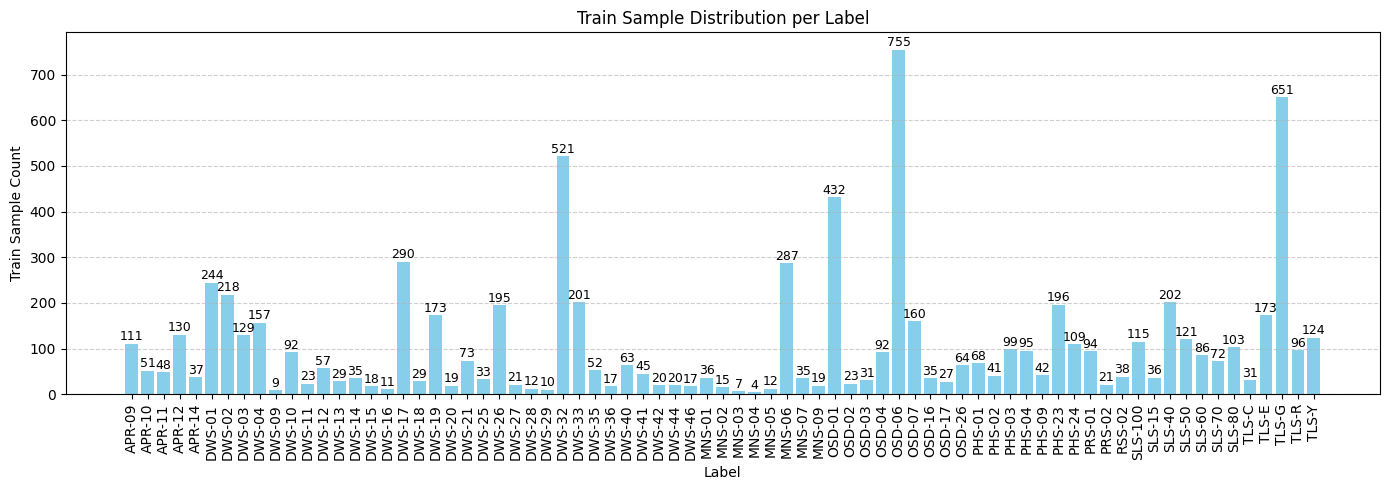

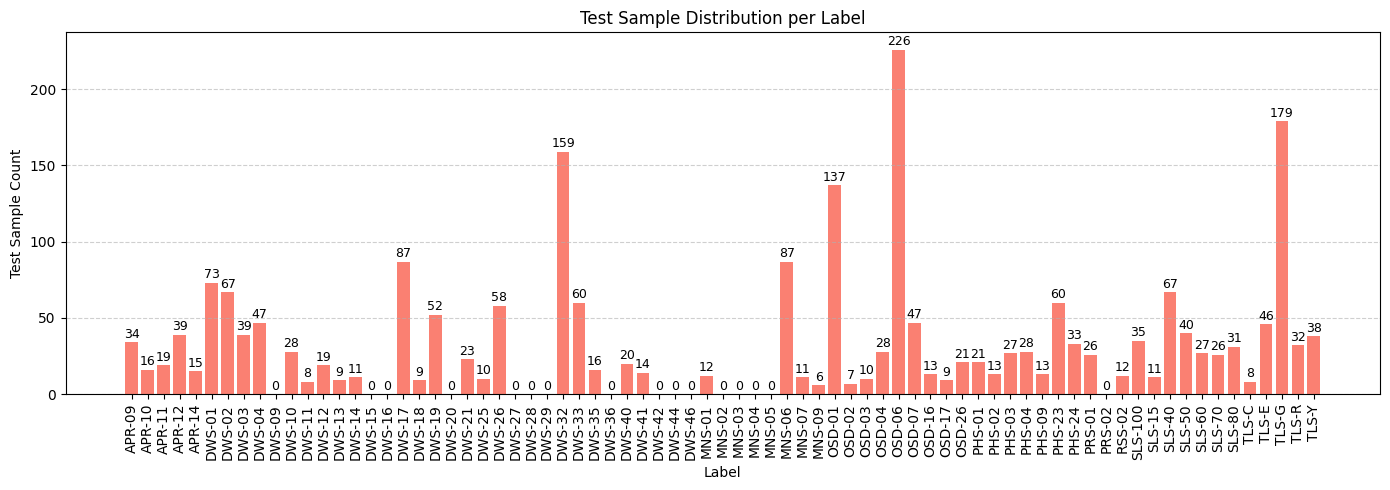

In [3]:
# Load and clean the data
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'])
df = df[df['Label'].str.lower() != 'total']

# --- Plot Train Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Train'], color='skyblue')
plt.title('Train Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Train Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot Test Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Test'], color='salmon')
plt.title('Test Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Test Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
!ls /content/dataset/Main

'label_frequencies.xlsx - Label Frequencies.csv'   sample   test   train


In [5]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd

# Define base dataset directory
base_dir = './dataset/Main'

# Create destination structure
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f'./final_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'./final_dataset/{split}/labels', exist_ok=True)

# Read class labels from Excel
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']
class_list = df['Label'].tolist()

# XML to YOLO format conversion
def convert_and_move(source_dir, img_files, target_split):
    for file in img_files:
        img_path = os.path.join(source_dir, file)
        xml_path = os.path.join(source_dir, file.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(img_path, f'./final_dataset/{target_split}/images/{file}')

        # Convert XML to YOLO
        tree = ET.parse(xml_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)

        with open(f'./final_dataset/{target_split}/labels/{file.replace(".jpg", ".txt")}', "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_list:
                    continue
                class_id = class_list.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                cx = ((xmin + xmax) / 2) / width
                cy = ((ymin + ymax) / 2) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# Process train set
train_dir = os.path.join(base_dir, 'train')
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
convert_and_move(train_dir, train_images, 'train')

# Split test into test and val (50/50)
test_dir = os.path.join(base_dir, 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
mid = len(test_images) // 2
val_images = test_images[:mid]
test_images = test_images[mid:]

convert_and_move(test_dir, val_images, 'val')
convert_and_move(test_dir, test_images, 'test')

<Figure size 1600x600 with 0 Axes>

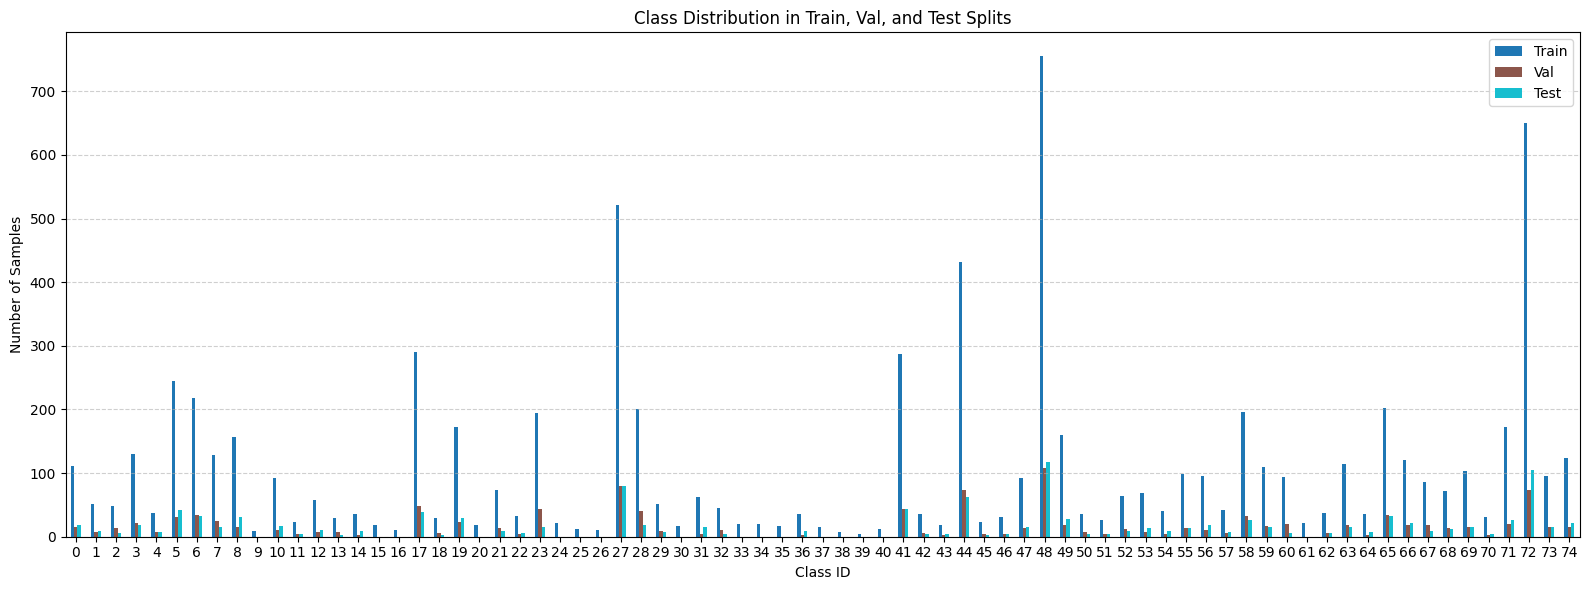

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define label folder paths
label_dirs = {
    'Train': './final_dataset/train/labels',
    'Val': './final_dataset/val/labels',
    'Test': './final_dataset/test/labels'
}

# Count class occurrences for each split
split_counts = {}
for split_name, label_path in label_dirs.items():
    class_counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            class_id = int(line.strip().split()[0])
                            class_counter[class_id] += 1
                        except ValueError:
                            continue
    split_counts[split_name] = class_counter

# Convert to DataFrame
df_dist = pd.DataFrame(split_counts).fillna(0).astype(int)
df_dist.index.name = 'Class ID'
df_dist = df_dist.sort_index()

# Plotting
plt.figure(figsize=(16, 6))
df_dist.plot(kind='bar', figsize=(16, 6), colormap='tab10')
plt.title('Class Distribution in Train, Val, and Test Splits')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

# Load class names from your Excel file
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')

# Drop "Total" column and row if present
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']

# Generate the 'names' YAML section
print("names:")
for idx, name in enumerate(df['Label']):
    print(f"  {idx}: {name}")


names:
  0: APR-09
  1: APR-10
  2: APR-11
  3: APR-12
  4: APR-14
  5: DWS-01
  6: DWS-02
  7: DWS-03
  8: DWS-04
  9: DWS-09
  10: DWS-10
  11: DWS-11
  12: DWS-12
  13: DWS-13
  14: DWS-14
  15: DWS-15
  16: DWS-16
  17: DWS-17
  18: DWS-18
  19: DWS-19
  20: DWS-20
  21: DWS-21
  22: DWS-25
  23: DWS-26
  24: DWS-27
  25: DWS-28
  26: DWS-29
  27: DWS-32
  28: DWS-33
  29: DWS-35
  30: DWS-36
  31: DWS-40
  32: DWS-41
  33: DWS-42
  34: DWS-44
  35: DWS-46
  36: MNS-01
  37: MNS-02
  38: MNS-03
  39: MNS-04
  40: MNS-05
  41: MNS-06
  42: MNS-07
  43: MNS-09
  44: OSD-01
  45: OSD-02
  46: OSD-03
  47: OSD-04
  48: OSD-06
  49: OSD-07
  50: OSD-16
  51: OSD-17
  52: OSD-26
  53: PHS-01
  54: PHS-02
  55: PHS-03
  56: PHS-04
  57: PHS-09
  58: PHS-23
  59: PHS-24
  60: PRS-01
  61: PRS-02
  62: RSS-02
  63: SLS-100
  64: SLS-15
  65: SLS-40
  66: SLS-50
  67: SLS-60
  68: SLS-70
  69: SLS-80
  70: TLS-C
  71: TLS-E
  72: TLS-G
  73: TLS-R
  74: TLS-Y


In [8]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uni

In [9]:
import torch
import torch.nn as nn
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
import torch
import torch.nn as nn
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # You can choose other variants like yolov8s.pt, yolov8m.pt, etc.

100%|██████████| 6.25M/6.25M [00:00<00:00, 320MB/s]


In [13]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolov8n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',  # 👈 path to your data.yaml
    epochs=100,                     # number of epochs
    imgsz=640,                      # input image size
    batch=64,                       # experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

100%|██████████| 755k/755k [00:00<00:00, 55.9MB/s]

Overriding model.yaml nc=80 with nc=75

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,113,715 parameters, 3,113,699 gradients, 8.7 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 392MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2762.6±1726.6 MB/s, size: 650.3 KB)


train: Scanning /content/final_dataset/train/labels... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:04<00:00, 1517.79it/s]


train: New cache created: /content/final_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2895.3±1995.5 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<00:00, 1227.47it/s]

val: New cache created: /content/final_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000127, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.31G       1.39      6.714      1.009        142        640: 100%|██████████| 96/96 [00:46<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


                   all        920       1155     0.0109      0.131     0.0238     0.0188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.08G      1.299      5.024     0.9466        129        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        920       1155       0.48      0.136     0.0721     0.0554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       9.1G      1.227      4.044     0.9314        149        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.423      0.223      0.152       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.12G      1.157      3.419     0.9138        152        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.479      0.284      0.214       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.14G      1.128      2.982      0.909        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.532      0.321      0.266      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.15G      1.077      2.688     0.8983        138        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.429      0.371      0.303      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.17G      1.057      2.443     0.8943        137        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.455      0.388      0.352      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.19G      1.036       2.24      0.894        136        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.469      0.409      0.384      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.21G      1.025      2.145      0.891        164        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.509      0.425      0.419      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.22G      1.015      1.998     0.8909        125        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        920       1155      0.564      0.436      0.446       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.24G      1.008      1.901     0.8874        136        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.513      0.481      0.458       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.26G     0.9714      1.759     0.8822        128        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.624      0.437      0.461      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.28G     0.9849      1.701     0.8819        168        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.594      0.476      0.493      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.29G     0.9719      1.612      0.883        134        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        920       1155      0.625       0.49      0.513      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.31G     0.9507      1.517     0.8791        145        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.642       0.48      0.512      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.33G     0.9461      1.467     0.8788        147        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.652      0.503      0.525      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.35G     0.9598      1.464     0.8772        148        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.614      0.547      0.553      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.37G     0.9326      1.392     0.8764        155        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.671      0.501      0.546      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.38G     0.9375      1.348     0.8753        115        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.731      0.494      0.554       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       9.4G     0.9323      1.314     0.8723        155        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.637      0.512      0.558      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.42G     0.9094      1.249     0.8674        140        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155      0.708      0.534      0.569      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.44G     0.8975      1.205     0.8645        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


                   all        920       1155      0.721      0.531      0.585      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.45G     0.9064      1.182     0.8654        147        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.718      0.541      0.587      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.47G     0.9003      1.144      0.864        152        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155       0.64      0.569      0.587       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.49G     0.8862       1.11     0.8641        131        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        920       1155       0.75      0.529      0.597       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.51G     0.8924      1.117     0.8647        125        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.686       0.57      0.605      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.53G     0.8899       1.08     0.8646        150        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.772      0.552      0.622      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.54G     0.8779      1.045     0.8636        132        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.688      0.566      0.608      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.56G     0.8741       1.03     0.8601        145        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155       0.75      0.552      0.611      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.58G     0.8669      1.013     0.8603        139        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.727      0.575      0.618        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       9.6G      0.869     0.9984     0.8603        152        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155       0.73       0.57      0.619      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.61G     0.8674     0.9866     0.8577        130        640: 100%|██████████| 96/96 [00:41<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.757      0.563       0.64      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.63G     0.8712     0.9814     0.8585        164        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.767      0.553      0.631      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.65G     0.8544     0.9465     0.8562        112        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        920       1155      0.733      0.604      0.663      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.67G     0.8372     0.9191     0.8522        123        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.753      0.597      0.649      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.68G     0.8412     0.9092     0.8518        159        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.763      0.557      0.641      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       9.7G     0.8411     0.8977     0.8538        136        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        920       1155      0.776      0.599      0.662      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.72G     0.8426     0.8923     0.8556        151        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155        0.8      0.588      0.659      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.74G     0.8525     0.9027     0.8579        115        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.739      0.606      0.666       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.75G     0.8304     0.8505     0.8532        142        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        920       1155      0.783      0.591      0.667      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.77G     0.8227     0.8607     0.8491        125        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.774      0.591      0.668      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.79G     0.8443     0.8583     0.8536        114        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.841      0.581      0.678       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.81G     0.8249      0.838     0.8514        129        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.745      0.602      0.675      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.82G     0.8172     0.8283      0.849        123        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


                   all        920       1155      0.734      0.612      0.673      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.84G     0.8202     0.8342     0.8476        142        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        920       1155      0.759      0.622      0.682       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.86G     0.8111     0.8086       0.85        147        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.762      0.603      0.666      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.88G     0.8217     0.8101     0.8474        138        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.803      0.598      0.678      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.89G     0.8164     0.7974     0.8484        183        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.809      0.617      0.696      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.91G     0.8202      0.801     0.8471        153        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        920       1155        0.8      0.606       0.68      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.93G     0.8039     0.7861     0.8472        142        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


                   all        920       1155       0.75      0.636      0.682      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.95G     0.7899     0.7587     0.8445        145        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.808      0.619      0.695      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.96G     0.8018     0.7707     0.8462        134        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.837      0.596      0.696      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.98G     0.8077     0.7679     0.8466        143        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155       0.81       0.63      0.693      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100        10G     0.7945     0.7546     0.8423        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        920       1155      0.773      0.626      0.686      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100        10G      0.793     0.7503     0.8439        135        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.803      0.633      0.707      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100        10G     0.7973     0.7468     0.8419        121        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.813      0.622      0.702       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.1G     0.7801     0.7303     0.8406        162        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.801      0.622      0.693      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.1G     0.7962     0.7436     0.8449        139        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.796      0.642      0.706      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.1G     0.8019     0.7322     0.8453        128        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.805      0.651      0.715      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.1G     0.7847     0.7181     0.8431        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.824      0.634      0.713      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.1G     0.7688     0.6997     0.8405        175        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.853      0.628      0.722       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.1G     0.7798      0.717     0.8441        158        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.784      0.662      0.715      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.2G     0.7891      0.719     0.8424        132        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.828      0.634       0.72      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.2G     0.7736     0.7026     0.8412        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.821      0.645      0.718      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.2G     0.7684     0.6991     0.8405        145        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.773       0.67      0.719      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.2G     0.7773     0.7023      0.841        144        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.849      0.649      0.724      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.2G     0.7674     0.6917      0.838        145        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.825      0.648      0.733       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.2G     0.7752     0.6947     0.8388        118        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.757      0.672      0.723      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.3G     0.7736     0.6858      0.841        146        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.841      0.637      0.725      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.3G     0.7717     0.6889     0.8399        140        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.843      0.648      0.726      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.3G      0.755     0.6581     0.8372        159        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.744      0.696      0.725      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.3G     0.7626     0.6727     0.8369        153        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.783      0.678      0.725      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.3G     0.7565     0.6652      0.835        113        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.778      0.672      0.727       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.4G      0.752     0.6535     0.8378        144        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155       0.77       0.68      0.728      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.4G     0.7686     0.6792     0.8366        150        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        920       1155      0.865      0.651      0.733      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.4G     0.7553     0.6606      0.839        139        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.835      0.654      0.741      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.4G     0.7494     0.6558     0.8347        140        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


                   all        920       1155       0.82       0.66      0.737      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.4G     0.7463     0.6408     0.8342        118        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155       0.76      0.684      0.735      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.4G     0.7552     0.6591     0.8383        121        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.783      0.671      0.741      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.5G     0.7461     0.6467     0.8365        134        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.821      0.656      0.736      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      10.5G     0.7501     0.6494     0.8357        150        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.813      0.669      0.744      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      10.5G     0.7424      0.629     0.8341        152        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155      0.769      0.699      0.739      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.5G     0.7415     0.6363     0.8315        148        640: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.812      0.665       0.74      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      10.5G     0.7364     0.6267     0.8346        141        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.754      0.706      0.741      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.5G     0.7526     0.6389     0.8339        151        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.782      0.691      0.743      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.6G     0.7296     0.6171     0.8336        139        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155        0.8      0.676      0.745      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.6G      0.739     0.6323     0.8343        133        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.823      0.664      0.746      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.6G     0.7265      0.624     0.8327        120        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.827      0.652      0.737      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      10.6G     0.7294     0.6194     0.8329        151        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155        0.8      0.673      0.742      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.6G     0.7385     0.6248     0.8351        135        640: 100%|██████████| 96/96 [00:41<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.798      0.674      0.741      0.602
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.7G     0.7557     0.6674     0.8439         86        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.747      0.693      0.735      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.7G     0.7253     0.6001     0.8388         78        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155      0.772      0.689      0.737       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.7G     0.7092     0.5886      0.834         81        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155       0.77      0.685      0.742      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.7G     0.7064     0.5775      0.832         70        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.754       0.69      0.744      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.7G     0.6992     0.5726     0.8331         69        640: 100%|██████████| 96/96 [00:40<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


                   all        920       1155      0.774      0.688      0.742      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.7G     0.6977     0.5689     0.8325         89        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155       0.79      0.683      0.744      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.8G     0.7008     0.5695     0.8315         82        640: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.777      0.693      0.746      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.8G     0.7052     0.5744     0.8291         70        640: 100%|██████████| 96/96 [00:41<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        920       1155      0.768      0.687      0.745      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.8G     0.6963     0.5685     0.8339         69        640: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.769      0.694      0.747      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.8G     0.6893     0.5619     0.8303         78        640: 100%|██████████| 96/96 [00:40<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.771      0.696      0.747      0.599

100 epochs completed in 1.269 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,108,449 parameters, 0 gradients, 8.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


                   all        920       1155      0.822      0.664      0.746      0.604
                APR-09         15         15      0.842      0.712      0.718      0.518
                APR-10          7          7      0.916      0.714       0.96      0.811
                APR-11         13         13      0.892          1      0.995      0.765
                APR-12         21         21      0.835      0.723      0.826      0.616
                APR-14          8          8      0.804       0.75      0.802      0.633
                DWS-01         31         31      0.946      0.968      0.993      0.896
                DWS-02         34         34      0.982      0.971      0.989        0.9
                DWS-03         24         24      0.847      0.917      0.975      0.883
                DWS-04         16         16      0.873       0.86      0.923      0.837
                DWS-10         11         11      0.906          1      0.988      0.816
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787c691305d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

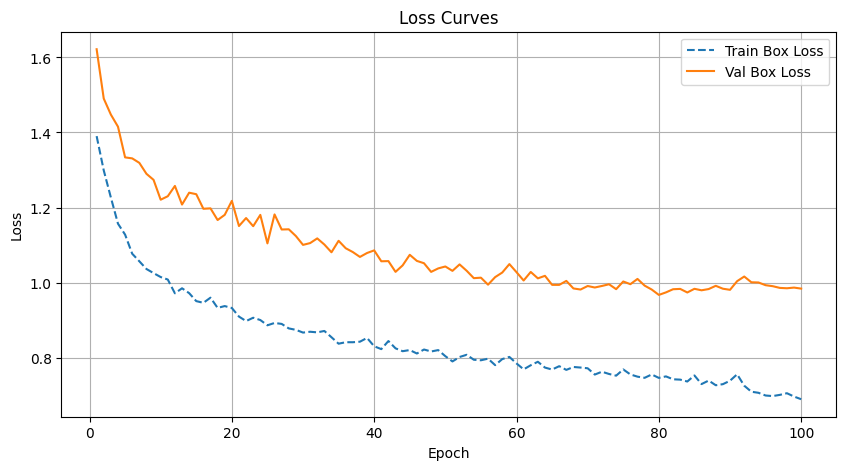

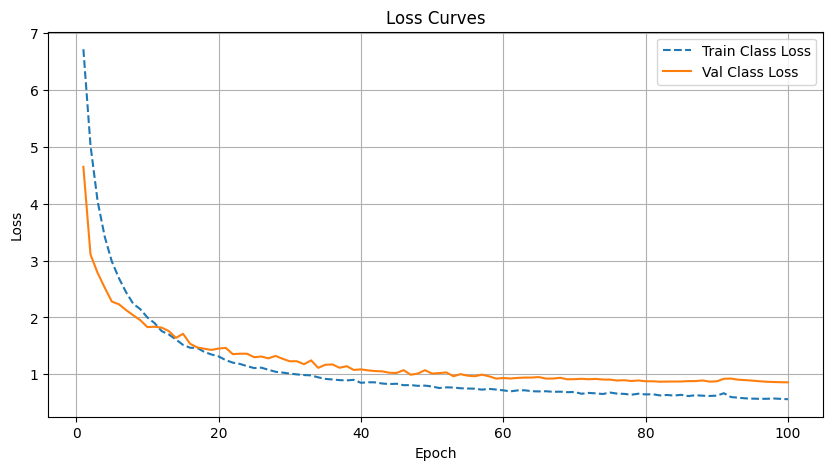

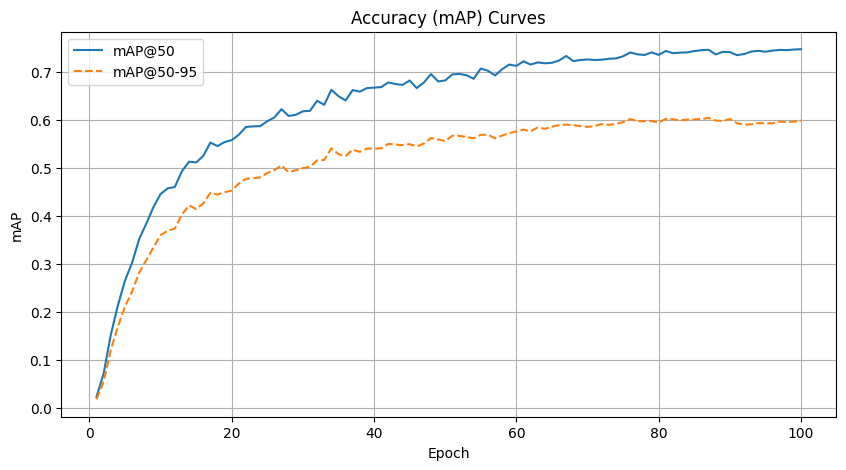

In [14]:
# Load the CSV file
results_path = "/content/runs/detect/train/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [15]:
results = model.val()
print(results)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,108,449 parameters, 0 gradients, 8.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4345.5±924.9 MB/s, size: 714.2 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


                   all        920       1155      0.822      0.663      0.746      0.605
                APR-09         15         15      0.841      0.705      0.718      0.516
                APR-10          7          7      0.917      0.714       0.96      0.811
                APR-11         13         13      0.891          1      0.995      0.771
                APR-12         21         21      0.835      0.723      0.826      0.627
                APR-14          8          8      0.804       0.75      0.802      0.633
                DWS-01         31         31       0.95      0.968      0.992      0.899
                DWS-02         34         34      0.982      0.971      0.989      0.899
                DWS-03         24         24      0.847      0.917      0.976      0.887
                DWS-04         16         16      0.873      0.859      0.923      0.828
                DWS-10         11         11      0.908          1      0.988      0.811
                DWS-1

In [18]:
from thop import profile
from ultralytics import YOLO
import torch

# ✅ Load model properly
model = YOLO('/content/runs/detect/train/weights/best.pt')
torch_model = model.model  # Raw nn.Module

# ✅ Create dummy input
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_tensor = torch.randn(1, 3, 640, 640).to(device)

# ✅ Move model to same device
torch_model = torch_model.to(device)

# ✅ Profile
macs, params = profile(torch_model, inputs=(input_tensor,), verbose=False)

# ✅ Print results
print(f"Params: {params / 1e6:.2f} Million")
print(f"MACs: {macs / 1e9:.2f} GMACs")
print(f"FLOPs: {2 * macs / 1e9:.2f} GFLOPs (approx)")

Params: 3.11 Million
MACs: 4.33 GMACs
FLOPs: 8.66 GFLOPs (approx)


In [22]:
from ultralytics import YOLO

# Load your trained YOLOv8n model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # change path if needed

# Evaluate on validation set
metrics = model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,108,449 parameters, 0 gradients, 8.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3923.6±977.2 MB/s, size: 623.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 11.11it/s]


                   all        920       1155      0.821      0.664      0.746      0.604
                APR-09         15         15      0.841      0.708      0.718      0.516
                APR-10          7          7      0.918      0.714       0.96      0.811
                APR-11         13         13       0.89          1      0.995      0.771
                APR-12         21         21      0.835      0.724      0.826      0.627
                APR-14          8          8      0.803       0.75      0.802      0.621
                DWS-01         31         31      0.949      0.968      0.992      0.899
                DWS-02         34         34      0.982      0.971      0.989      0.899
                DWS-03         24         24      0.847      0.917      0.975      0.886
                DWS-04         16         16      0.873       0.86      0.923      0.828
                DWS-10         11         11      0.907          1      0.988       0.81
                DWS-1

In [27]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # update path if needed

# Run validation
metrics = model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,108,449 parameters, 0 gradients, 8.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3649.0±235.3 MB/s, size: 640.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 11.03it/s]


                   all        920       1155      0.821      0.664      0.746      0.604
                APR-09         15         15      0.841      0.708      0.718      0.516
                APR-10          7          7      0.918      0.714       0.96      0.811
                APR-11         13         13       0.89          1      0.995      0.771
                APR-12         21         21      0.835      0.724      0.826      0.627
                APR-14          8          8      0.803       0.75      0.802      0.621
                DWS-01         31         31      0.949      0.968      0.992      0.899
                DWS-02         34         34      0.982      0.971      0.989      0.899
                DWS-03         24         24      0.847      0.917      0.975      0.886
                DWS-04         16         16      0.873       0.86      0.923      0.828
                DWS-10         11         11      0.907          1      0.988       0.81
                DWS-1

In [26]:
# Extract metrics from `metrics.box`
precision = metrics.box.p.mean()       # mean precision
recall = metrics.box.r.mean()          # mean recall
map50 = metrics.box.ap50.mean()        # mAP@0.5
map5095 = metrics.box.ap.mean()        # mAP@0.5:0.95

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Print summary
print("\n✅ 📊 Overall Evaluation Summary:")
print(f"{'Metric':<15} | {'Value':>8}")
print(f"{'-'*26}")
print(f"{'mAP@50':<15} | {map50:.3f}")
print(f"{'mAP@50-95':<15} | {map5095:.3f}")
print(f"{'Precision':<15} | {precision:.3f}")
print(f"{'Recall':<15} | {recall:.3f}")
print(f"{'F1-Score':<15} | {f1_score:.3f}")


✅ 📊 Overall Evaluation Summary:
Metric          |    Value
--------------------------
mAP@50          | 0.746
mAP@50-95       | 0.604
Precision       | 0.821
Recall          | 0.664
F1-Score        | 0.734
